# Model and data import

In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from mass import MassSolution, Simulation
from mass.enzyme_modules import EnzymeModuleForm
from mass.io.json import load_json_model
from mass.visualization import plot_comparison, plot_time_profile

from mass.util.expressions import strip_time

In [2]:
reference_model_wo_enzymes =  load_json_model(
    filename=f"./models/mass/without_enzymes/Glycolysis_Ref_wo_Enzymes.json")

reference_model_w_enzymes =  load_json_model(
    filename=f"./models/mass/with_enzymes/Glycolysis_Ref_w_Enzymes.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-01-21


In [3]:
isozymes = {
    "PFK": ["PFK1", "PFK2"],
    "FBP": ["FBP1", "FBP2"],
    "FBA": ["FBA1", "FBA2"],
    "PGM": ["PGMi", "PGMd"],
    "PYK": ["PYK1", "PYK2"],
}
        
isozymes

{'PFK': ['PFK1', 'PFK2'],
 'FBP': ['FBP1', 'FBP2'],
 'FBA': ['FBA1', 'FBA2'],
 'PGM': ['PGMi', 'PGMd'],
 'PYK': ['PYK1', 'PYK2']}

In [4]:
reference_model_wo_enzymes

Name,Glycolysis_Ref_wo_Enzymes
Memory address,0x07fbef85a3d00
Stoichiometric Matrix,20x28
Matrix Rank,19
Number of metabolites,20
Initial conditions defined,20/20
Number of reactions,28
Number of genes,19
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [5]:
reference_model_w_enzymes

Name,Glycolysis_Ref_w_Enzymes
Memory address,0x07fbec87a06d0
Stoichiometric Matrix,120x122
Matrix Rank,102
Number of metabolites,120
Initial conditions defined,120/120
Number of reactions,122
Number of genes,19
Number of enzyme modules,17
Number of groups,0
Objective expression,0


# Data Analysis with kinetic and thermodynamic models

### Comparing initial data vs. computed adjustments

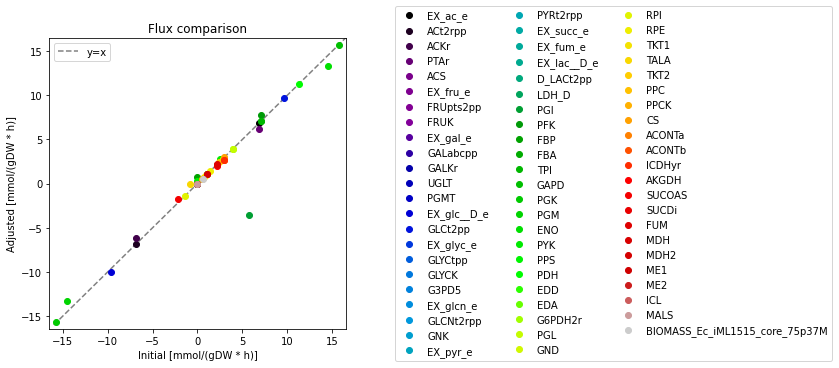

In [6]:
flux_data = pd.read_csv("./data/analysis_data/fluxes.csv", index_col=0)

flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_data["Initial"], y=flux_data["Adjusted"], ax=ax,
    title="Flux comparison",
    legend="right outside", plot_function="plot",
    xlim=(-16.5, 16.5), ylim=(-16.5, 16.5),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()

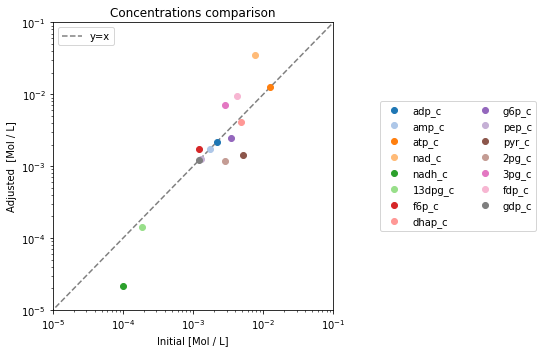

In [7]:
conc_data = pd.read_csv("./data/analysis_data/concentrations.csv", index_col=0)

conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=conc_data["Initial"], y=conc_data["Adjusted"], ax=ax,
    title="Concentrations comparison",
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), 
    xy_line=True,
    xy_legend="best", xlabel="Initial [Mol / L]", ylabel="Adjusted  [Mol / L]")

conc_comparison_fig.tight_layout()

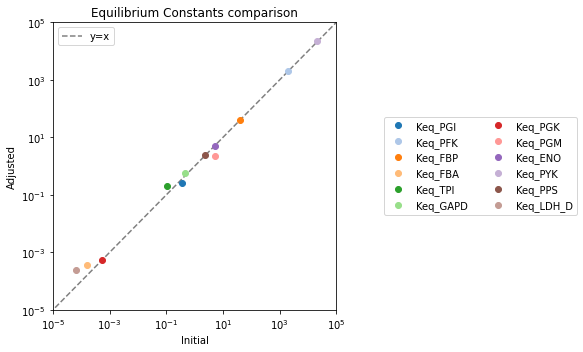

In [8]:
Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
    title="Equilibrium Constants comparison",
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
    xy_line=True,
    xy_legend="best", xlabel="Initial", ylabel="Adjusted")

Keq_data_comparison_fig.tight_layout()

## Comparing estimated and real enzyme concentrations

In [9]:
literature_enzyme_conc_data = pd.read_csv(
    "./data/analysis_data/literature_enz_concs.csv",
    index_col=0)
estimated_enzyme_conc_data = pd.DataFrame.from_dict({
    enzyme.id:  enzyme.enzyme_concentration_total
    for enzyme in reference_model_w_enzymes.enzyme_modules
}, orient="index")

enz_data_for_comparison = pd.concat(
    objs=(literature_enzyme_conc_data, estimated_enzyme_conc_data), 
    axis=1)

enz_data_for_comparison.index.name = "ID"
enz_data_for_comparison.columns = ["Literature", "Estimated"]
enz_data_for_comparison.to_csv("./data/analysis_data/lit_vs_estimated_enzymes.csv")
enz_data_for_comparison

,Literature,Estimated
ID,,
PGI,1.091450e-05,0.000121
PFK1,3.435440e-06,0.049157
PFK2,2.227410e-06,0.000017
FBP1,2.239090e-06,0.000013
FBP2,4.444320e-07,0.001874
FBA1,4.756010e-05,0.016505
FBA2,5.123290e-06,0.046105
TPI,1.764510e-05,0.000299
GAPD,1.116910e-04,0.003450


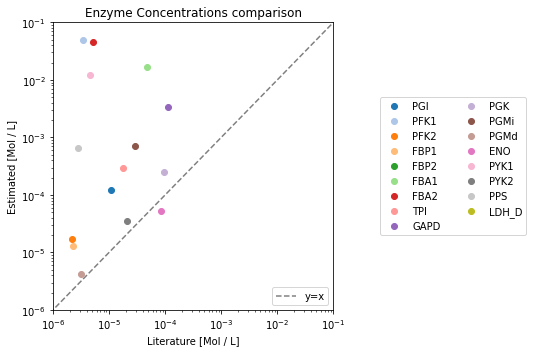

In [10]:

enz_data_for_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=enz_data_for_comparison["Literature"],
    y=enz_data_for_comparison["Estimated"], ax=ax,
    title="Enzyme Concentrations comparison",
    legend="right outside", plot_function="loglog",
    xlim=(1e-6, 1e-1), ylim=(1e-6, 1e-1), xy_line=True,
    xy_legend="best", xlabel="Literature [Mol / L]", ylabel="Estimated [Mol / L]")

enz_data_for_comparison_fig.tight_layout()

## Analyzing metabolomics data

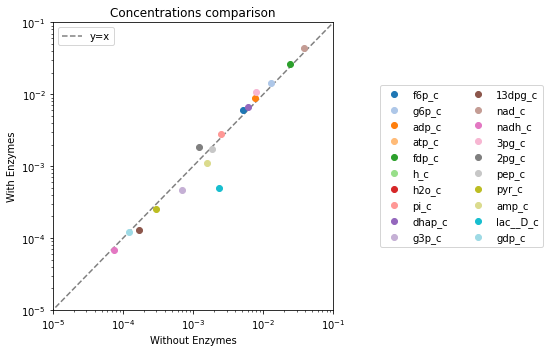

In [11]:
wo_enzymes = pd.DataFrame.from_dict({
    metabolite.id: initial_condition
    for metabolite, initial_condition in reference_model_wo_enzymes.initial_conditions.items()
}, orient="index")

w_enzymes = pd.DataFrame.from_dict({
    metabolite.id: initial_condition
    for metabolite, initial_condition in reference_model_w_enzymes.initial_conditions.items()
}, orient="index")

to_compare = pd.concat(
    objs=(wo_enzymes, w_enzymes), 
    axis=1).dropna()

to_compare.index.name = "ID"
to_compare.columns = ["Without Enzymes", "With Enzymes"]

conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=to_compare["Without Enzymes"], y=to_compare["With Enzymes"], ax=ax,
    title="Concentrations comparison",
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 1e-1), ylim=(1e-5, 1e-1), 
    xy_line=True,
    xy_legend="best", xlabel="Without Enzymes", ylabel= "With Enzymes")

conc_comparison_fig.tight_layout()

### Concentrations vs. Disequilibrium

In [12]:
diseq_expressions = strip_time(reference_model_wo_enzymes.get_disequilibrium_ratios())
diseq_expressions = {
    reaction.id: diseq for reaction, diseq in diseq_expressions.items()
    if not reaction.boundary
}
diseq_expressions

{'PGI': f6p_c/(Keq_PGI*g6p_c),
 'PFK': adp_c*fdp_c/(Keq_PFK*atp_c*f6p_c),
 'FBP': f6p_c*pi_c/(Keq_FBP*fdp_c),
 'FBA': dhap_c*g3p_c/(Keq_FBA*fdp_c),
 'TPI': g3p_c/(Keq_TPI*dhap_c),
 'GAPD': _13dpg_c*nadh_c/(Keq_GAPD*g3p_c*nad_c*pi_c),
 'PGK': _13dpg_c*adp_c/(Keq_PGK*_3pg_c*atp_c),
 'PGM': _3pg_c/(Keq_PGM*_2pg_c),
 'ENO': pep_c/(Keq_ENO*_2pg_c),
 'PYK': atp_c*pyr_c/(Keq_PYK*adp_c*pep_c),
 'PPS': amp_c*pep_c*pi_c/(Keq_PPS*atp_c*pyr_c),
 'LDH_D': nadh_c*pyr_c/(Keq_LDH_D*lac__D_c*nad_c)}

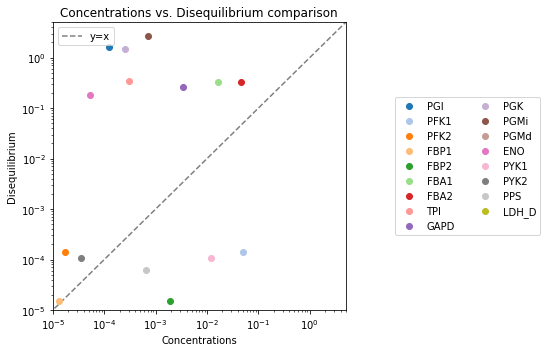

In [13]:
model = reference_model_w_enzymes
diseq_data = {}

# Equilibrium constants into expressions, (in reference w/o enzymes)
Keq_values = {r.Keq_str: r.Keq for r in reference_model_wo_enzymes.reactions}
for rid, expr in diseq_expressions.items():
    # Concentrations into expressions
    expr = expr.subs({m.id: m.ic for m in model.metabolites})
    expr = expr.subs({b: ic for b, ic in model.boundary_conditions.items()})
    expr = expr.subs(Keq_values)
    
    if rid not in isozymes:
        diseq_data[rid] = float(expr)
    else:
        for isozyme_id in isozymes[rid]:
            diseq_data[isozyme_id] = float(expr)

diseq_data = pd.DataFrame.from_dict(diseq_data, orient="index")
to_compare = pd.concat(
    objs=(estimated_enzyme_conc_data, diseq_data), 
    axis=1)

to_compare.columns = ["Concentrations", "Disequilibrium"]

conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=to_compare["Concentrations"], y=to_compare["Disequilibrium"], ax=ax,
    title="Concentrations vs. Disequilibrium comparison",
    legend="right outside", plot_function="loglog",
    xlim=(1e-5, 5), ylim=(1e-5, 5), 
    xy_line=True,
    xy_legend="best", xlabel="Concentrations", ylabel= "Disequilibrium")

conc_comparison_fig.tight_layout()

## Ensemble

In [14]:
n_models = 5
ensemble = []
for i in range(n_models):
    model = load_json_model(
        filename=f"./models/mass/with_enzymes/Glycolysis_C{i}.json")
    
    print(f"Loaded {model.id}")
    ensemble += [model]

Loaded Glycolysis_C0
Loaded Glycolysis_C1
Loaded Glycolysis_C2
Loaded Glycolysis_C3
Loaded Glycolysis_C4


### Calculating thermodynamic distance from equilibrium

In [15]:
T = 313.15
R = 8.314 / 1000 # kJ / mol·K

df = pd.DataFrame()
for model in ensemble:
    diseq_data = {}
    for rid, expr in diseq_expressions.items():
        # Concentrations into expressions
        expr = expr.subs({m.id: m.ic for m in model.metabolites})
        expr = expr.subs({b: ic for b, ic in model.boundary_conditions.items()})
        expr = expr.subs(Keq_values)
        diseq_data[rid] = R * T * np.log10(float(expr))
        

    data = pd.DataFrame.from_dict(diseq_data, orient="index")
    data.columns = [model.id]


    df = pd.concat(objs=(df, data), axis=1)
df = df.T
df

,PGI,PFK,FBP,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,PPS,LDH_D
Glycolysis_C0,0.548624,-10.018907,-12.537396,-1.269416,-1.197392,-1.526059,0.428112,1.093757,-1.948875,-10.335971,-10.932569,1.378149
Glycolysis_C1,1.196450,-5.083407,-13.033919,-1.745690,-1.231166,-2.034799,2.776201,1.261661,-2.711275,-12.647743,-4.747889,0.015182
Glycolysis_C2,1.252524,-6.572653,-10.603823,-2.624363,-2.151157,-4.057947,1.725654,3.293694,-1.889356,-12.929657,-4.068454,-0.073605
Glycolysis_C3,1.025471,-6.501497,-9.784502,-1.513018,-2.357665,-2.605609,2.260670,3.864608,-1.655141,-14.558203,-4.493749,0.006576
Glycolysis_C4,1.456162,-6.787664,-10.095693,-3.973421,-1.229553,-2.968019,1.622749,3.606490,-2.025124,-13.353968,-5.081331,-0.001703


#### Plot

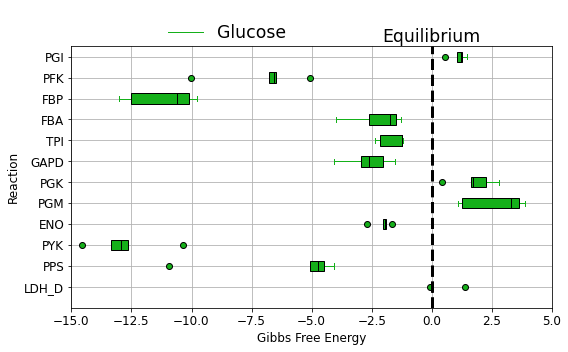

In [16]:
color = "xkcd:green"
fontsize = "xx-large"
cols = list(df.columns)
cols.reverse()
ax, boxes = df.boxplot(
    column=cols, figsize=(8, 5), vert=False,
    fontsize="large", patch_artist=True, return_type="both")
line = ax.plot([0, 0], [0, 12.5], linestyle=":", color="black", linewidth=3)
ax.set_xlim([-15, 5])
ax.set_ylim([0, 12.5])

line = ax.plot([0, 0], [0, 12.5], c="k", ls="--", label="Equilibrium", zorder=2,lw=3)
ax.annotate("Equilibrium", xy=(line[0].get_xdata()[-1],
                               line[0].get_ydata()[-1]),
            xytext=(-50, 10),
            xycoords="data", textcoords="offset points",
            size=fontsize, va="center")
legend_items = {}

for key, color in zip(
   ["whiskers", "caps", "boxes", "fliers", "medians"],
   [color] * 4 + ["black"]):
    for item in boxes[key]:
        if key in ["boxes", "fliers"]:
            col = list(mpl.colors.to_rgba(color))
            if key == "boxes":
                item.set_color("black")
                item.set_facecolor(col)
                item.set_linewidth(1)
            else:
                item.set_markerfacecolor(col)
                item.set_markeredgewidth(1)
                item.set_markeredgecolor("black")
        else:
            item.set_color(color)
    legend_items["Glucose"] = list(boxes["boxes"])
ax.legend(
    legend_items, **dict(
    loc="center right",
    bbox_to_anchor=(0.5, 1.05),
    fontsize=fontsize,
    borderpad=1,
    frameon=False))
ax.set_xlabel("Gibbs Free Energy", fontdict={"size": "large"})
ax.set_ylabel("Reaction", fontdict={"size": "large"})
ax.get_figure().tight_layout()


### Calculating enzyme bound states

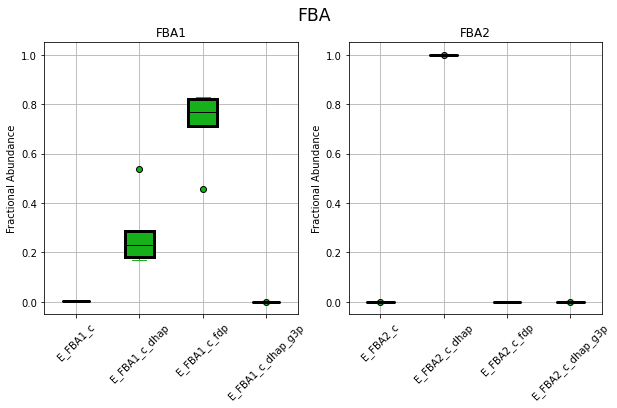

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

isoenzymes_of_interest = "FBA"

for i, enzyme_of_interest in enumerate(isozymes[isoenzymes_of_interest]):
    fractional_abundance_per_form_per_model = {}
    for model in ensemble:
        enzyme_module = model.enzyme_modules.get_by_id(enzyme_of_interest)
        e_total = sum([e.ic for e in enzyme_module.enzyme_module_forms])
        fractional_abundance_per_form_per_model[model.id] = {
            e.id: e.ic / e_total for e in enzyme_module.enzyme_module_forms
        }
    df = pd.DataFrame.from_dict(fractional_abundance_per_form_per_model).T
    
    ax, boxes = df.boxplot(
        ax=axes[i], vert=True, patch_artist=True,  rot=45, return_type="both")
    ax.set_ylim([-0.05, 1.05])
    ax.set_ylabel("Fractional Abundance")
    ax.set_title(enzyme_of_interest)
    color="xkcd:green"
    for key, color in zip(
       ["whiskers", "caps", "boxes", "fliers", "medians"],
       [color] * 4 + ["black"]):
        for item in boxes[key]:
            if key in ["boxes", "fliers"]:
                col = list(mpl.colors.to_rgba(color))
                if key == "boxes":
                    item.set_color("black")
                    item.set_facecolor(col)
                    item.set_linewidth(3)
                else:
                    item.set_markerfacecolor(col)
                    item.set_markeredgewidth(1)
                    item.set_markeredgecolor("black")
            else:
                item.set_color(color)
fig = ax.get_figure()
fig.suptitle(isoenzymes_of_interest, fontsize="xx-large");

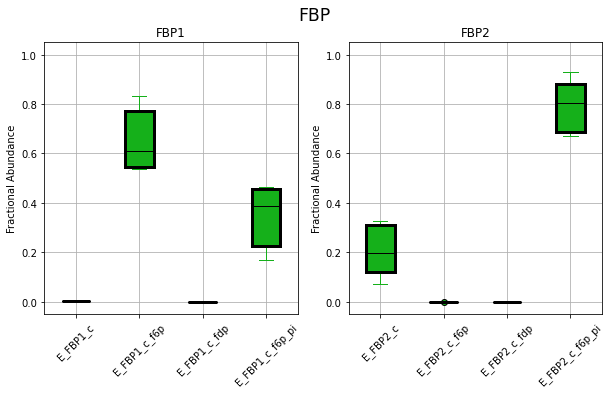

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

isoenzymes_of_interest = "FBP"

for i, enzyme_of_interest in enumerate(isozymes[isoenzymes_of_interest]):
    fractional_abundance_per_form_per_model = {}
    for model in ensemble:
        enzyme_module = model.enzyme_modules.get_by_id(enzyme_of_interest)
        e_total = sum([e.ic for e in enzyme_module.enzyme_module_forms])
        fractional_abundance_per_form_per_model[model.id] = {
            e.id: e.ic / e_total for e in enzyme_module.enzyme_module_forms
        }
    df = pd.DataFrame.from_dict(fractional_abundance_per_form_per_model).T
    
    ax, boxes = df.boxplot(
        ax=axes[i], vert=True, patch_artist=True,  rot=45, return_type="both")
    ax.set_ylim([-0.05, 1.05])
    ax.set_ylabel("Fractional Abundance")
    ax.set_title(enzyme_of_interest)
    color="xkcd:green"
    for key, color in zip(
       ["whiskers", "caps", "boxes", "fliers", "medians"],
       [color] * 4 + ["black"]):
        for item in boxes[key]:
            if key in ["boxes", "fliers"]:
                col = list(mpl.colors.to_rgba(color))
                if key == "boxes":
                    item.set_color("black")
                    item.set_facecolor(col)
                    item.set_linewidth(3)
                else:
                    item.set_markerfacecolor(col)
                    item.set_markeredgewidth(1)
                    item.set_markeredgecolor("black")
            else:
                item.set_color(color)
fig = ax.get_figure()
fig.suptitle(isoenzymes_of_interest, fontsize="xx-large");

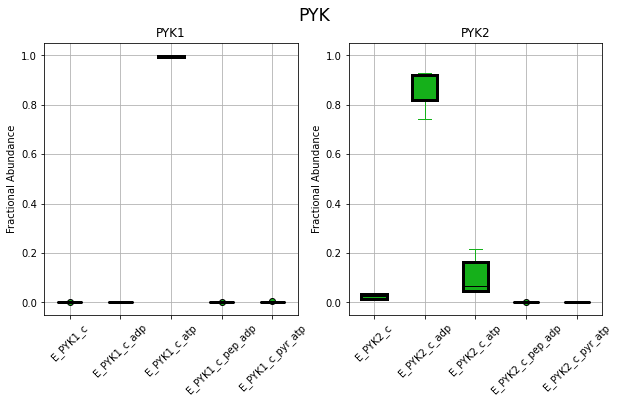

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

isoenzymes_of_interest = "PYK"

for i, enzyme_of_interest in enumerate(isozymes[isoenzymes_of_interest]):
    fractional_abundance_per_form_per_model = {}
    for model in ensemble:
        enzyme_module = model.enzyme_modules.get_by_id(enzyme_of_interest)
        e_total = sum([e.ic for e in enzyme_module.enzyme_module_forms])
        fractional_abundance_per_form_per_model[model.id] = {
            e.id: e.ic / e_total for e in enzyme_module.enzyme_module_forms
        }
    df = pd.DataFrame.from_dict(fractional_abundance_per_form_per_model).T
    
    ax, boxes = df.boxplot(
        ax=axes[i], vert=True, patch_artist=True,  rot=45, return_type="both")
    ax.set_ylim([-0.05, 1.05])
    ax.set_ylabel("Fractional Abundance")
    ax.set_title(enzyme_of_interest)
    color="xkcd:green"
    for key, color in zip(
       ["whiskers", "caps", "boxes", "fliers", "medians"],
       [color] * 4 + ["black"]):
        for item in boxes[key]:
            if key in ["boxes", "fliers"]:
                col = list(mpl.colors.to_rgba(color))
                if key == "boxes":
                    item.set_color("black")
                    item.set_facecolor(col)
                    item.set_linewidth(3)
                else:
                    item.set_markerfacecolor(col)
                    item.set_markeredgewidth(1)
                    item.set_markeredgecolor("black")
            else:
                item.set_color(color)
fig = ax.get_figure()
fig.suptitle(isoenzymes_of_interest, fontsize="xx-large");

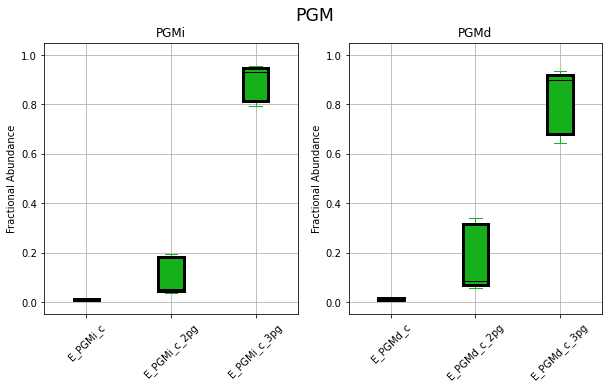

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

isoenzymes_of_interest = "PGM"

for i, enzyme_of_interest in enumerate(isozymes[isoenzymes_of_interest]):
    fractional_abundance_per_form_per_model = {}
    for model in ensemble:
        enzyme_module = model.enzyme_modules.get_by_id(enzyme_of_interest)
        e_total = sum([e.ic for e in enzyme_module.enzyme_module_forms])
        fractional_abundance_per_form_per_model[model.id] = {
            e.id: e.ic / e_total for e in enzyme_module.enzyme_module_forms
        }
    df = pd.DataFrame.from_dict(fractional_abundance_per_form_per_model).T
    
    ax, boxes = df.boxplot(
        ax=axes[i], vert=True, patch_artist=True,  rot=45, return_type="both")
    ax.set_ylim([-0.05, 1.05])
    ax.set_ylabel("Fractional Abundance")
    ax.set_title(enzyme_of_interest)
    color="xkcd:green"
    for key, color in zip(
       ["whiskers", "caps", "boxes", "fliers", "medians"],
       [color] * 4 + ["black"]):
        for item in boxes[key]:
            if key in ["boxes", "fliers"]:
                col = list(mpl.colors.to_rgba(color))
                if key == "boxes":
                    item.set_color("black")
                    item.set_facecolor(col)
                    item.set_linewidth(3)
                else:
                    item.set_markerfacecolor(col)
                    item.set_markeredgewidth(1)
                    item.set_markeredgecolor("black")
            else:
                item.set_color(color)
fig = ax.get_figure()
fig.suptitle(isoenzymes_of_interest, fontsize="xx-large");

# Simulating kinetic models for strain design

In [21]:
reference_model_w_enzymes

Name,Glycolysis_Ref_w_Enzymes
Memory address,0x07fbec87a06d0
Stoichiometric Matrix,120x122
Matrix Rank,102
Number of metabolites,120
Initial conditions defined,120/120
Number of reactions,122
Number of genes,19
Number of enzyme modules,17
Number of groups,0
Objective expression,0


## Enzyme concentration perturbations
### Ensure model is at steady state

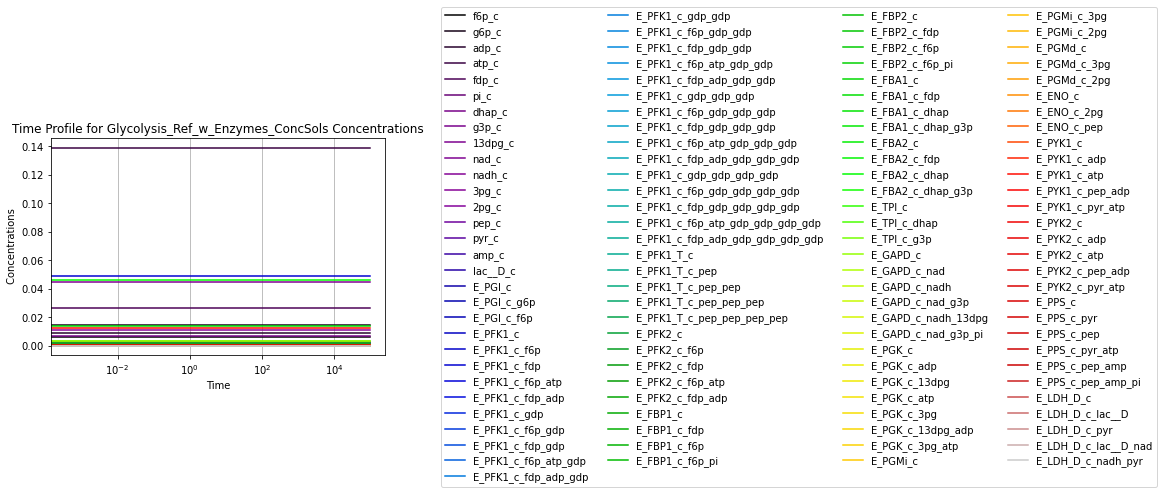

In [22]:
model = reference_model_w_enzymes

sim = Simulation(model)
conc_sol, flux_sol = sim.simulate(
    model,
    time=(0, 1e5),
)
conc_sol.view_time_profile(plot_function="semilogx")

### Perturb LDH_D concentration
LDH_D currently is at 0 in the system. What happens if it gets added in?

In [23]:
def calc_flux_through_enzyme(flux_sol):
    for enzyme_module in model.enzyme_modules:
        equation = " + ".join([
            enz_reaction.id for enz_reaction in enzyme_module.enzyme_module_reactions
            if "Activation" not in enz_reaction.id and "Inhibition" not in enz_reaction.id
            and "Transition" not in enz_reaction.id])
        flux_sol.make_aggregate_solution(
            aggregate_id=enzyme_module.id,
            equation=equation
        )
        
    return flux_sol

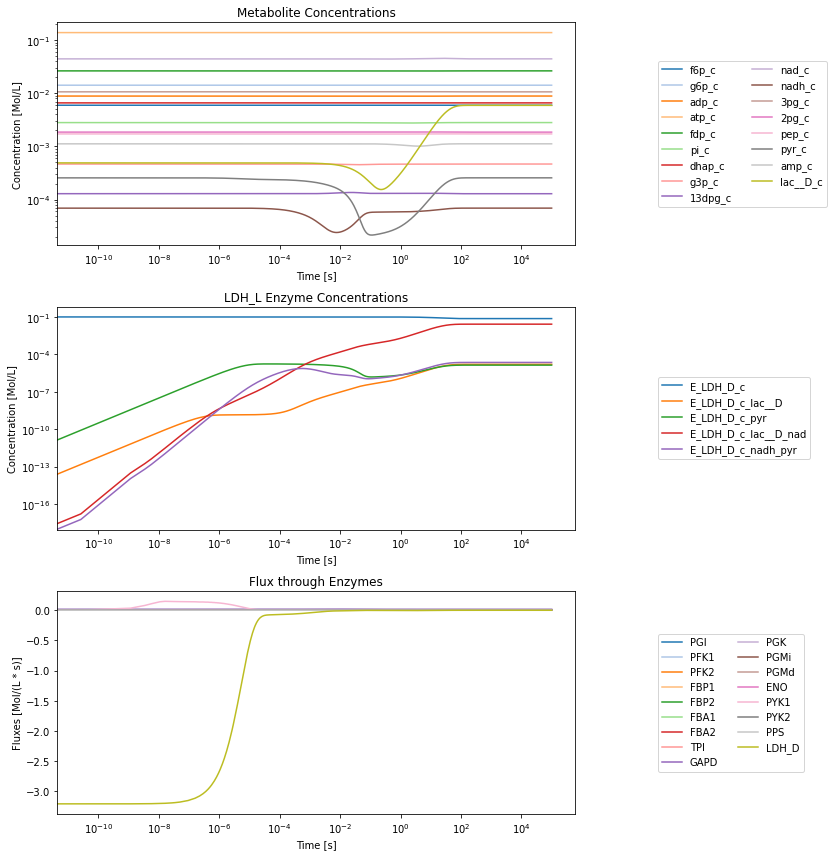

In [24]:
conc_sol, flux_sol = sim.simulate(
    model,
    time=(0, 1e5),
    perturbations={"E_LDH_D_c": 1e-1}
)


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

flux_sol = calc_flux_through_enzyme(flux_sol)

plot_time_profile(
    conc_sol, ax=axes[0], observable=[
        m.id for m in model.metabolites
        if not isinstance(m, EnzymeModuleForm) and not m.fixed
    ], plot_function="loglog", title="Metabolite Concentrations",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    legend="right outside"
    )

plot_time_profile(
    conc_sol, ax=axes[1], observable=[
        m.id for m in model.metabolites
        if isinstance(m, EnzymeModuleForm) and m.id.startswith("E_LDH")
    ], plot_function="loglog", title="LDH_L Enzyme Concentrations",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    legend="right outside"
    )

plot_time_profile(
    flux_sol, ax=axes[2], observable=[
        e.id for e in model.enzyme_modules
    ], plot_function="semilogx", title="Flux through Enzymes",
    xlabel="Time [s]", ylabel="Fluxes [Mol/(L * s)]",
    legend="right outside",
    )
fig.tight_layout()

### Perturb pair of isozymes

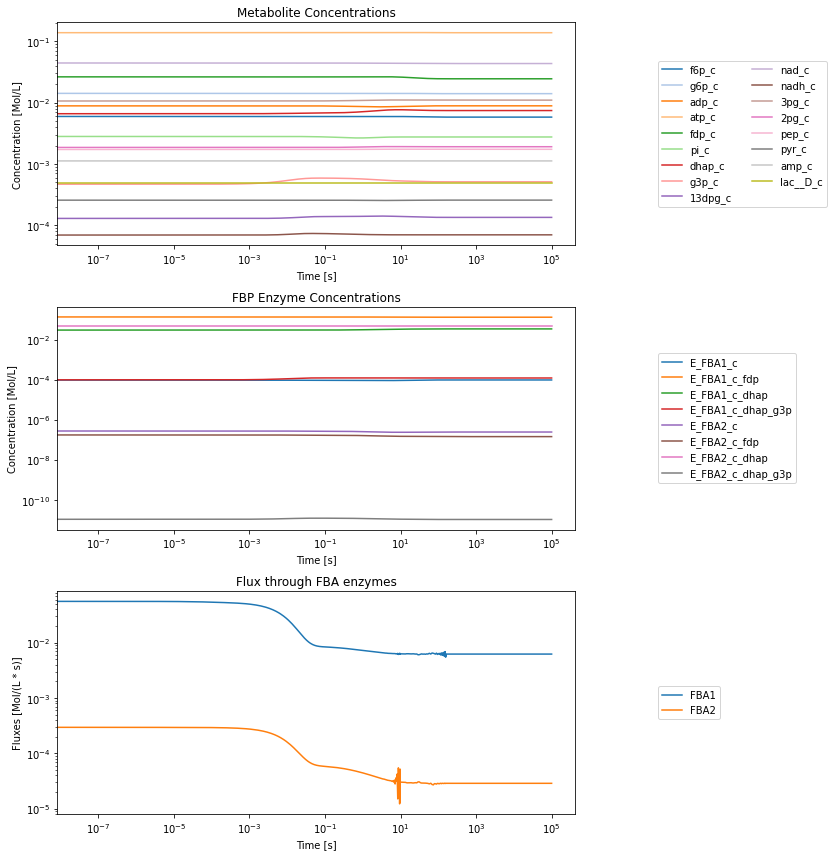

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

conc_sol, flux_sol = sim.simulate(
    model,
    time=(0, 1e5),
    perturbations={e.id: e.ic * 10
         for enzyme in reference_model_w_enzymes.enzyme_modules.get_by_any(["FBA1"])
         for e in enzyme.enzyme_module_forms
         }
)

flux_sol = calc_flux_through_enzyme(flux_sol)

plot_time_profile(
    conc_sol, ax=axes[0], observable=[
        m.id for m in model.metabolites
        if not isinstance(m, EnzymeModuleForm) and not m.fixed
    ], plot_function="loglog", title="Metabolite Concentrations",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    legend="right outside"
    )

plot_time_profile(
    conc_sol, ax=axes[1], observable=[
        m.id for m in model.metabolites
        if isinstance(m, EnzymeModuleForm) and m.id.startswith("E_FBA")
    ], plot_function="loglog", title="FBP Enzyme Concentrations",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    legend="right outside"
    )

plot_time_profile(
    flux_sol, ax=axes[2], observable=[
        e.id for e in model.enzyme_modules
        if e.id.startswith("FBA")
    ], plot_function="loglog", title="Flux through FBA enzymes",
    xlabel="Time [s]", ylabel="Fluxes [Mol/(L * s)]",
    legend="right outside",
    )
fig.tight_layout()

### Perturb key metabolites

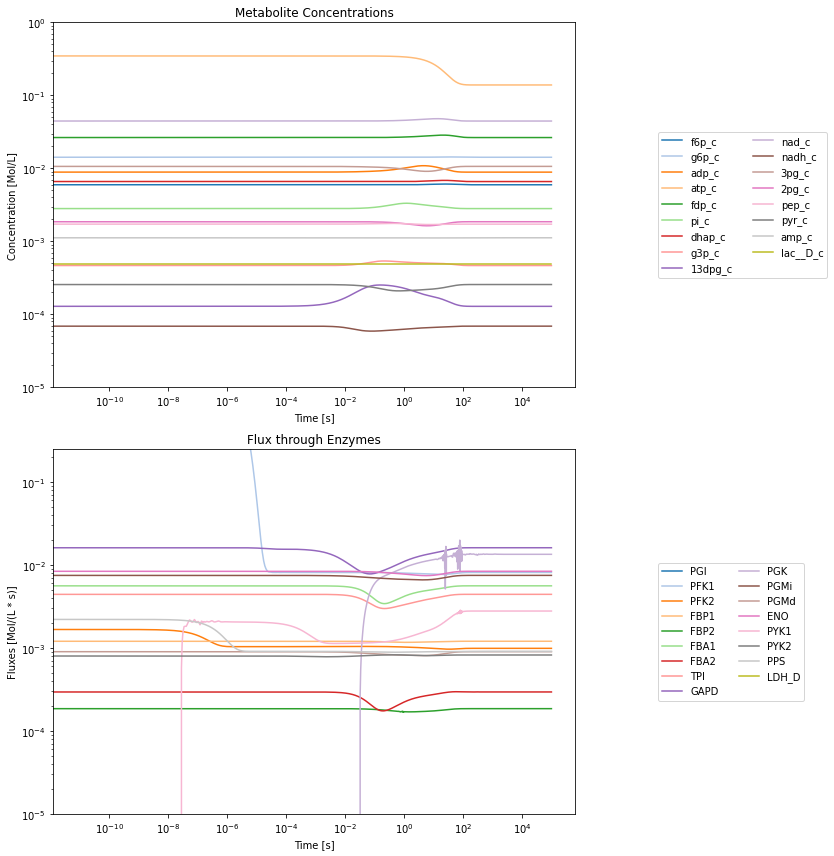

In [26]:
conc_sol, flux_sol = sim.simulate(
    model,
    time=(0, 1e5),
    perturbations={"atp_c": "atp_c * 2.5",}
)

flux_sol = calc_flux_through_enzyme(flux_sol)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))



plot_time_profile(
    conc_sol, ax=axes[0], observable=[
        m.id for m in model.metabolites
        if not isinstance(m, EnzymeModuleForm) and not m.fixed
    ], plot_function="loglog", title="Metabolite Concentrations",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    legend="right outside",
    ylim=(1e-5, 1),
    )


plot_time_profile(
    flux_sol, ax=axes[1], observable=[
        e.id for e in model.enzyme_modules
    ], plot_function="loglog", title="Flux through Enzymes",
    xlabel="Time [s]", ylabel="Fluxes [Mol/(L * s)]",
    legend="right outside",
    ylim=(1e-5, 0.25),
    )
fig.tight_layout()

### Perturb all enzymes

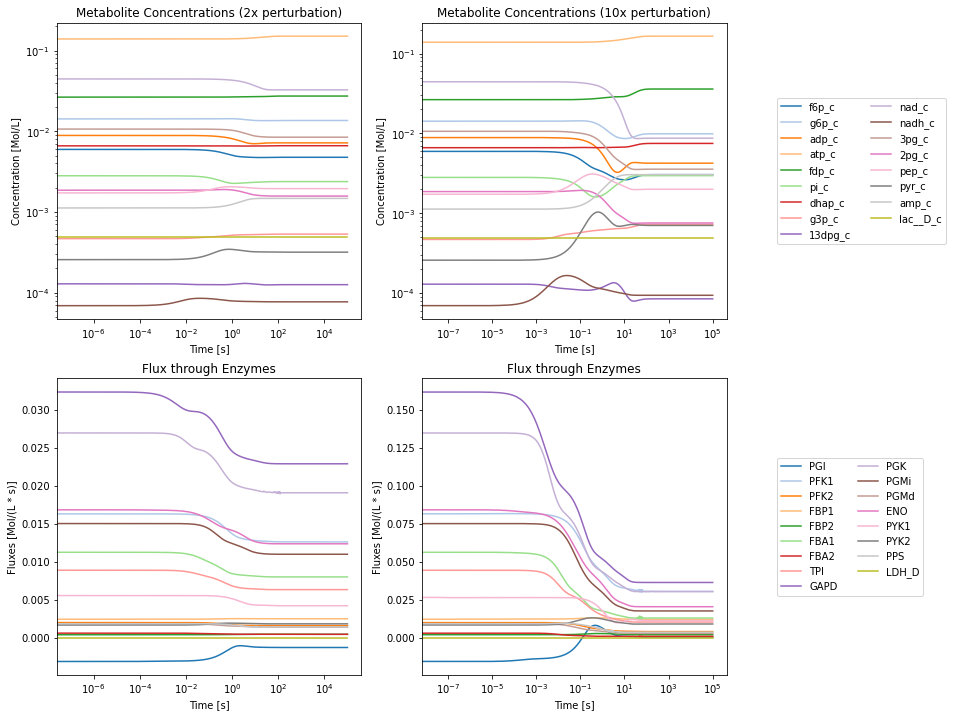

In [27]:
# 2x
conc_sol_2x, flux_sol_2x = sim.simulate(
    model,
    time=(0, 1e5),
    perturbations={
        e.id: e.ic * 2
        for enzyme in reference_model_w_enzymes.enzyme_modules
        for e in enzyme.enzyme_module_forms
     }
)

conc_sol_10x, flux_sol_10x = sim.simulate(
    model,
    time=(0, 1e5),
    perturbations={
        e.id: e.ic * 10
        for enzyme in reference_model_w_enzymes.enzyme_modules
        for e in enzyme.enzyme_module_forms
     }
)


flux_sol_2x = calc_flux_through_enzyme(flux_sol_2x)
flux_sol_10x = calc_flux_through_enzyme(flux_sol_10x)


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()

plot_time_profile(
    conc_sol_2x, ax=axes[0], observable=[
        m.id for m in model.metabolites
        if not isinstance(m, EnzymeModuleForm) and not m.fixed
    ], plot_function="loglog", title="Metabolite Concentrations (2x perturbation)",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    )

plot_time_profile(
    conc_sol_10x, ax=axes[1], observable=[
        m.id for m in model.metabolites
        if not isinstance(m, EnzymeModuleForm) and not m.fixed
    ], plot_function="loglog", title="Metabolite Concentrations (10x perturbation)",
    xlabel="Time [s]", ylabel="Concentration [Mol/L]",
    legend="right outside"
    )

plot_time_profile(
    flux_sol_2x, ax=axes[2], observable=[
        e.id for e in model.enzyme_modules
    ], plot_function="semilogx", title="Flux through Enzymes",
    xlabel="Time [s]", ylabel="Fluxes [Mol/(L * s)]",
    )

plot_time_profile(
    flux_sol_10x, ax=axes[3], observable=[
        e.id for e in model.enzyme_modules
    ], plot_function="semilogx", title="Flux through Enzymes",
    xlabel="Time [s]", ylabel="Fluxes [Mol/(L * s)]",
    legend="right outside",
    )

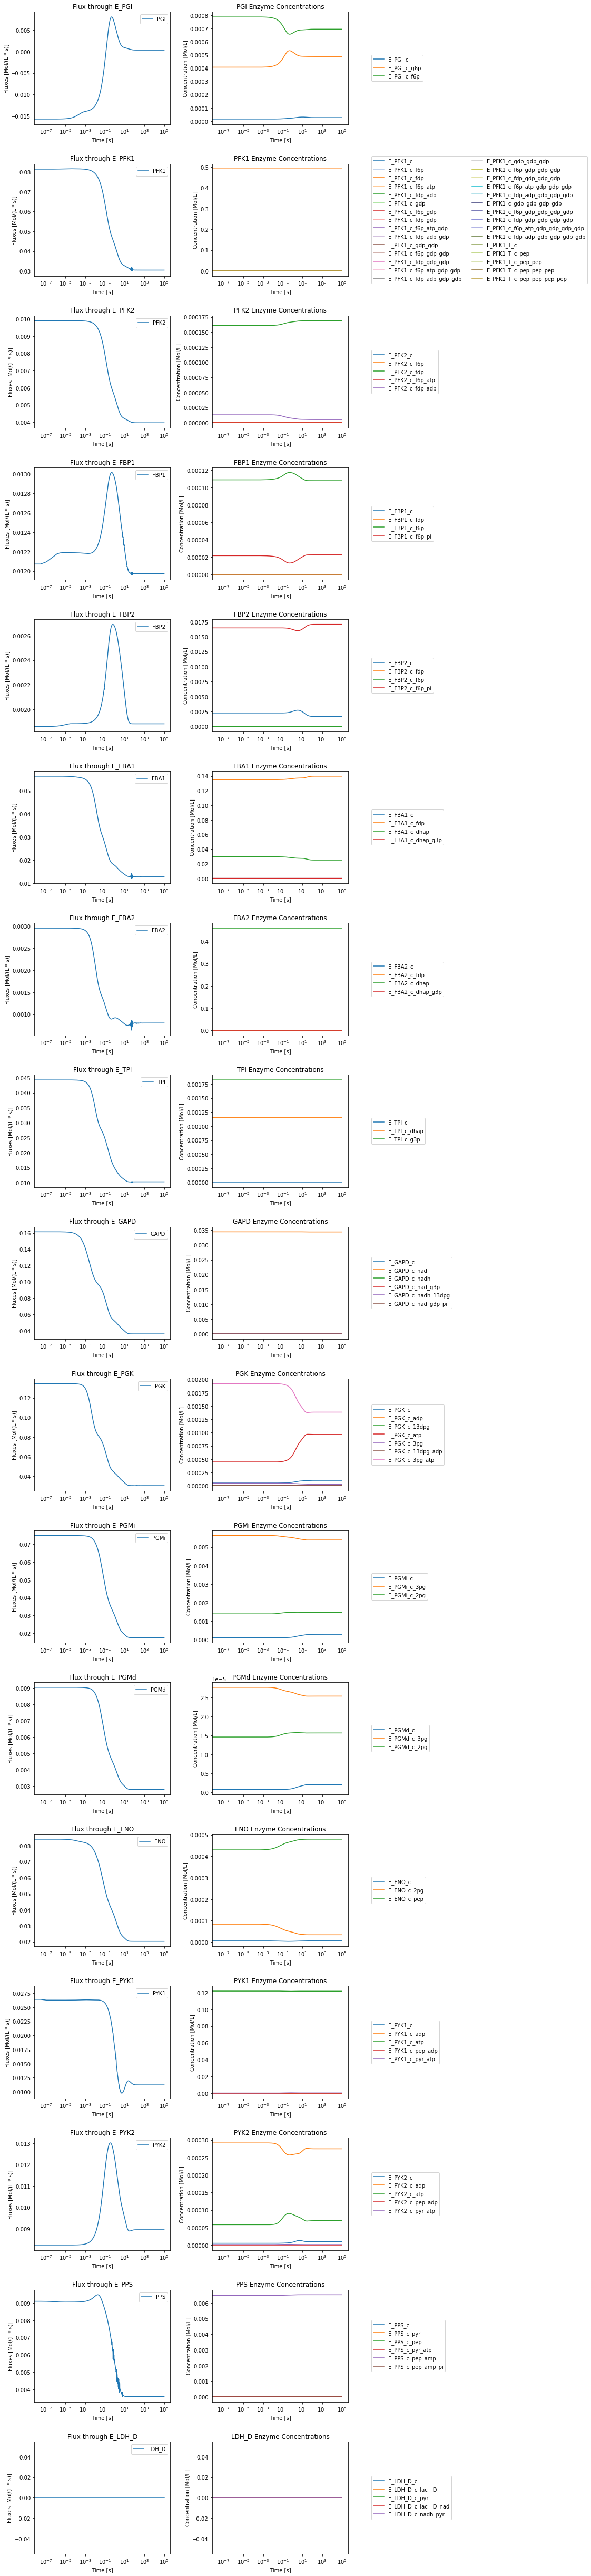

In [28]:
fig, axes = plt.subplots(nrows=len(model.enzyme_modules),
                         ncols=2,
                         figsize=(16, 4*len(model.enzyme_modules)))
flux_sol = calc_flux_through_enzyme(flux_sol)

for i, enzyme in enumerate(model.enzyme_modules):
    plot_time_profile(
        flux_sol_10x, ax=axes[i, 0], observable=[
            e.id for e in model.enzyme_modules
            if e.id.startswith(enzyme.id)
        ], plot_function="semilogx", title=f"Flux through E_{enzyme.id}",
        xlabel="Time [s]", ylabel="Fluxes [Mol/(L * s)]",
        legend="best",
        )
    
    plot_time_profile(
        conc_sol_10x, ax=axes[i, 1], observable=[
            m.id for m in model.metabolites
            if isinstance(m, EnzymeModuleForm) and m.id.startswith(f"E_{enzyme.id}")
        ], plot_function="semilogx", title=f"{enzyme.id} Enzyme Concentrations",
        xlabel="Time [s]", ylabel="Concentration [Mol/L]",
        legend="right outside"
        )
fig.tight_layout()